# ORB Feature Detection

https://docs.opencv.org/3.4.1/d1/d89/tutorial_py_orb.html

In [1]:
# init prerequisites
%reload_ext autoreload
%autoreload 2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os, re, math, time, random
from pprint import pprint

import util
from util import print_warn, horline

print("OpenCV {}".format(cv.__version__))
print("Numpy {}".format(np.__version__))

OpenCV 3.4.1
Numpy 1.16.2


In [2]:
# gasonics production equipment
config = dict(
    inputfolder=r".\input\reflector_r1\frames",
    outputfolder=r".\output\feature\orb",
    lookylooky=[
        (r".\input\reflector_r1\arrow.png", (0,0,203,148)),
        (r".\input\reflector_r1\3672.0.png", (0,120,300,300)),
        (r".\input\reflector_r1\996.0.png", (550,450,200,200)),
        (r".\input\reflector_r1\986.0.png", (742,202,413,327)),
    ],
)
pprint(config)

{'inputfolder': '.\\input\\reflector_r1\\frames',
 'lookylooky': [('.\\input\\reflector_r1\\arrow.png', (0, 0, 203, 148)),
                ('.\\input\\reflector_r1\\3672.0.png', (0, 120, 300, 300)),
                ('.\\input\\reflector_r1\\996.0.png', (550, 450, 200, 200)),
                ('.\\input\\reflector_r1\\986.0.png', (742, 202, 413, 327))],
 'outputfolder': '.\\output\\feature\\orb'}


In [3]:
def save_img(saveimg):
    os.makedirs(config["outputfolder"], exist_ok=True)
    imgpath = os.path.join(config["outputfolder"], os.path.basename(path))
    cv.imwrite(imgpath, saveimg)
    print("image saved to {}".format(imgpath))

def wait_and_hotkey(saveimg, delay: int=1) -> bool:
    k = cv.waitKey(10) & 0xff
    if k == 32:
        while True:
            k = cv.waitKey(10)
            if k == 27: return True
            elif k == 32: break
            elif k == ord('s'):
                save_img(saveimg)
    elif k == 27: return True
    elif k == ord('s'): 
        save_img(saveimg)
    return False

In [4]:
# needs a title :)
from enum import Enum
Method = Enum("Method", "SIFT ORB")
Matcher = Enum("Matcher", "BF FLANN")
method = Method.ORB
matcher = Matcher.BF

# wrapper around method specific data
class Storage(object):
    img = None
    kp = None
    des = None
    
    def __init__(self, img):
        self.img = img
        
    # find keypoints and compute descriptor
    def find_features(self):
        if method == Method.SIFT:
            self.kp, self.des = sift.detectAndCompute(self.img, None)
        elif method == Method.ORB:
            self.kp = orb.detect(self.img, None)
            self.kp, self.des = orb.compute(self.img, self.kp)
        else:
            raise Exception("Unknown Method: {}".format(method))

    # match self image to reference
    def match_images(self, reference, drawimg=None):
        output_images = []
        if matcher == Matcher.BF:
            try:
                matches = bf.match(reference.des,self.des)
                matches = sorted(matches, key = lambda x:x.distance)
                #matches = matches[0:int(len(matches) * 0.2)] # percent best matches
            except error as e:
                print(reference.des, self.des)
                raise e
        
        elif matcher == Matcher.FLANN:
            # select good matches as per Lowe's ratio test
            matches = flann.knnMatch(reference.des, self.des, k=2)
            good = []
            for m,n in matches:
                if m.distance < 0.75*n.distance:
                    good.append(m)
            matches = good
                
        dst = None
        #print("  found {} matches".format(len(matches)))
        if len(matches) >= 4:
            src_pts = np.float32([ reference.kp[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
            dst_pts = np.float32([      self.kp[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

            M, mask = cv.findHomography(src_pts, dst_pts, cv.RHO, 1)
            matchesMask = mask.ravel().tolist()

            if M is not None:
                h,w = feature1.shape
                pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
                dst = cv.perspectiveTransform(pts, M)

        if drawimg is not None:
            tmp = cv.drawMatches(reference.img,reference.kp,drawimg.copy(),self.kp,matches,None,flags=2)
            output_images.append(tmp)
            cv.imshow('matches', tmp)
            if dst is not None:
                tmp = cv.polylines(drawimg.copy(), [np.int32(dst)], True, 255, 3, cv.LINE_AA)
                output_images.append(tmp)
                cv.imshow('img', tmp)
        return output_images
            
sift = None
orb = None
def init_method():
    global sift, orb
    if method == Method.SIFT:
        sift = cv.xfeatures2d.SIFT_create()
    elif method == Method.ORB:
        orb = cv.ORB_create(nfeatures=2000, scaleFactor=1.4, nlevels=16, patchSize=11, edgeThreshold=10)
        #orb = cv.ORB_create(nfeatures=1500, scaleFactor=1.8, nlevels=2, patchSize=101, edgeThreshold=5)

bf = None
flann = None
def init_matcher():
    global bf, flann
    if matcher == Matcher.BF:
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    else:
        if method == Method.SIFT:
            index_params = dict(algorithm = 1, trees = 5)
        elif method == Method.ORB:
            index_params = dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1)
        search_params = dict(checks = 100)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        
init_method()

loading ('.\\input\\reflector_r1\\986.0.png', (742, 202, 413, 327)) as search image


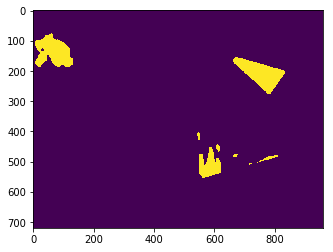

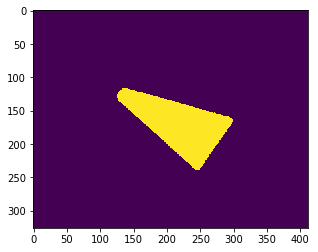

  found 134 keypoints in search image


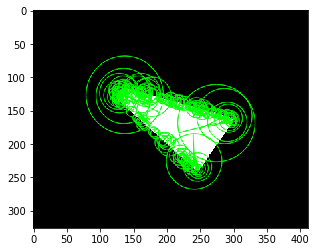

In [5]:
# read input image and store for future use
input_image_index = 3

print("loading {} as search image".format(config["lookylooky"][input_image_index]))
feature1 = cv.imread(config["lookylooky"][input_image_index][0], cv.IMREAD_GRAYSCALE)
x,y,w,h = config["lookylooky"][input_image_index][1]
plt.imshow(feature1); plt.show()

# crop
feature1 = feature1[y-int(h/2):y+int(h/2), x-int(w/2):x+int(w/2)]
plt.imshow(feature1); plt.show()
    
search = Storage(feature1)
search.find_features()

print("  found {} keypoints in search image".format(len(search.kp)))
tmp = cv.drawKeypoints(search.img, search.kp, None, color=(0,255,0), flags=4)
plt.imshow(tmp); plt.show()

In [6]:
# collect input files
paths, labels, label_mapping = util.recursive_collect(config["inputfolder"])
input_images = []
prev = None

print("{} contains {} images".format(config["inputfolder"], len(paths)))
shuffle = list(zip(paths, labels))
shuffle = sorted(shuffle, key = lambda x: int(x[0].split("\\")[-1].split(".")[0]))
paths, labels = zip(*shuffle)

# init image preprocessing
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


# config matcher
#  sift
index_params = dict(algorithm = 1, trees = 5)
#  orb
index_params = dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1)
search_params = dict(checks = 100)

# init matcher
init_matcher()

# prints information about mouse drags in window
area_temp_x = None
area_temp_y = None
def area_inspector(event, x, y, flags, param):
    global area_temp_x, area_temp_y
    if event == cv.EVENT_LBUTTONDOWN:
        area_temp_x = x
        area_temp_y = y
    if event == cv.EVENT_LBUTTONUP:
        ar = (area_temp_x, area_temp_y, x, y)
        print("[{},{}]".format(x,y),"[{},{}]".format(area_temp_x,area_temp_y))

# initialization of opencv windows
def init_window(title):
    cv.namedWindow(title, cv.WINDOW_NORMAL)
    cv.resizeWindow(title, 600, 500)
    cv.setMouseCallback(title, area_inspector)

cv.destroyAllWindows()
init_window('img')
init_window('gray')
#init_window('matches')
init_window('keypoints')

out = None
for i, path, label in zip(range(len(paths)), paths, labels):
    ## read input image
    img = cv.imread(path, cv.IMREAD_COLOR)
    
    #img = cv.resize(img, (int(img.shape[1]*0.5), int(img.shape[0]*0.5)))
    img = cv.medianBlur(img, 11)
    
    ## warp image to change perspective on image plane
    pts1 = np.float32([[126,292],[464,404],[392,580],[ 16,450]])
    pts2 = np.float32([[200,200],[650,200],[650,400],[200,400]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    img = cv.warpPerspective(img,M,(img.shape[1], img.shape[0]), borderMode=cv.BORDER_CONSTANT)

    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    #gray = clahe.apply(gray)
    #gray = cv.equalizeHist(gray)
    _, gray = cv.threshold(gray,230,255,cv.THRESH_BINARY)
    
    ## display and store for next iteration
    cv.imshow('gray', gray)
    prev = gray
    save = gray
    
    ## find features and descriptors
    current = Storage(gray)
    current.find_features()

    imgs = current.match_images(search, drawimg=img)
    save = imgs[0]
    
    ## display keypoint location
    img2 = cv.drawKeypoints(img, current.kp, None, color=(0,255,0), flags=4)
    cv.imshow('keypoints', img2)
    
    ## measure time
    #start_time = time.perf_counter()
    #end_time = time.perf_counter()
    #print("  computation for {} took {:.2f}ms".format(path, (end_time - start_time)*1000.0))
    
    if wait_and_hotkey(gray, delay=1): break
    
if out is not None:
    out.release()
cv.destroyAllWindows()

.\input\reflector_r1\frames contains 795 images
image saved to .\output\feature\orb\1013.0.png
image saved to .\output\feature\orb\1044.0.png
image saved to .\output\feature\orb\1561.0.png


In [ ]:
    # write video
    #if out is None:
    #    outh,outw,_ = bgr.shape
    #    out = cv.VideoWriter(os.path.join(config["outputfolder"], "orb5.avi"), cv.VideoWriter_fourcc(*'MJPG'), 10, (outw,outh))
    #vidimg = cv.addWeighted(bgr, 0.5, img, 0.5, 0)
    #out.write(vidimg)

In [ ]:
if out is not None:
    out.release()
cv.destroyAllWindows()